## Classification Project

### **Preparation**

### Import Libraries

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
)

### Load Dataset

In [2]:
# Load dataset
filename = "data/sonar.all-data.csv"
dataset = pd.read_csv(filename, header=None)

### **Analyze Data**

In [3]:
# shape
print(dataset.shape)

(208, 61)


In [4]:
# types
print(dataset.dtypes)

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
56    float64
57    float64
58    float64
59    float64
60     object
Length: 61, dtype: object


In [5]:
# head
print(dataset.head(20))

        0       1       2       3       4       5       6       7       8   \
0   0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1   0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2   0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3   0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4   0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   
5   0.0286  0.0453  0.0277  0.0174  0.0384  0.0990  0.1201  0.1833  0.2105   
6   0.0317  0.0956  0.1321  0.1408  0.1674  0.1710  0.0731  0.1401  0.2083   
7   0.0519  0.0548  0.0842  0.0319  0.1158  0.0922  0.1027  0.0613  0.1465   
8   0.0223  0.0375  0.0484  0.0475  0.0647  0.0591  0.0753  0.0098  0.0684   
9   0.0164  0.0173  0.0347  0.0070  0.0187  0.0671  0.1056  0.0697  0.0962   
10  0.0039  0.0063  0.0152  0.0336  0.0310  0.0284  0.0396  0.0272  0.0323   
11  0.0123  0.0309  0.0169  0.0313  0.0358  0.0102  0.0182  0.05

In [6]:
# summary statistics
print(dataset.describe())

               0           1           2           3           4           5   \
count  208.000000  208.000000  208.000000  208.000000  208.000000  208.000000   
mean     0.029164    0.038437    0.043832    0.053892    0.075202    0.104570   
std      0.022991    0.032960    0.038428    0.046528    0.055552    0.059105   
min      0.001500    0.000600    0.001500    0.005800    0.006700    0.010200   
25%      0.013350    0.016450    0.018950    0.024375    0.038050    0.067025   
50%      0.022800    0.030800    0.034300    0.044050    0.062500    0.092150   
75%      0.035550    0.047950    0.057950    0.064500    0.100275    0.134125   
max      0.137100    0.233900    0.305900    0.426400    0.401000    0.382300   

               6           7           8           9   ...          50  \
count  208.000000  208.000000  208.000000  208.000000  ...  208.000000   
mean     0.121747    0.134799    0.178003    0.208259  ...    0.016069   
std      0.061788    0.085152    0.118387    0.1

In [7]:
# class distribution
print(dataset.groupby(60).size())

60
M    111
R     97
dtype: int64


### Univariate Data Visualizations

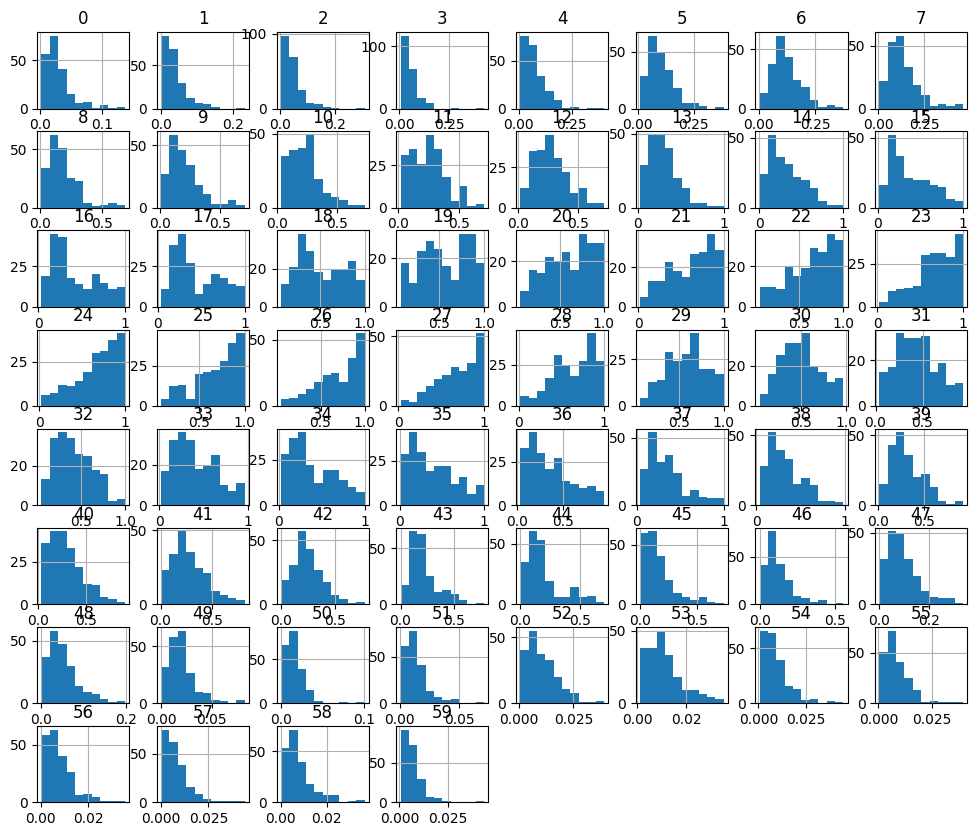

In [8]:
# histogram of each attribute
dataset.hist(figsize=(12, 10))
plt.show()

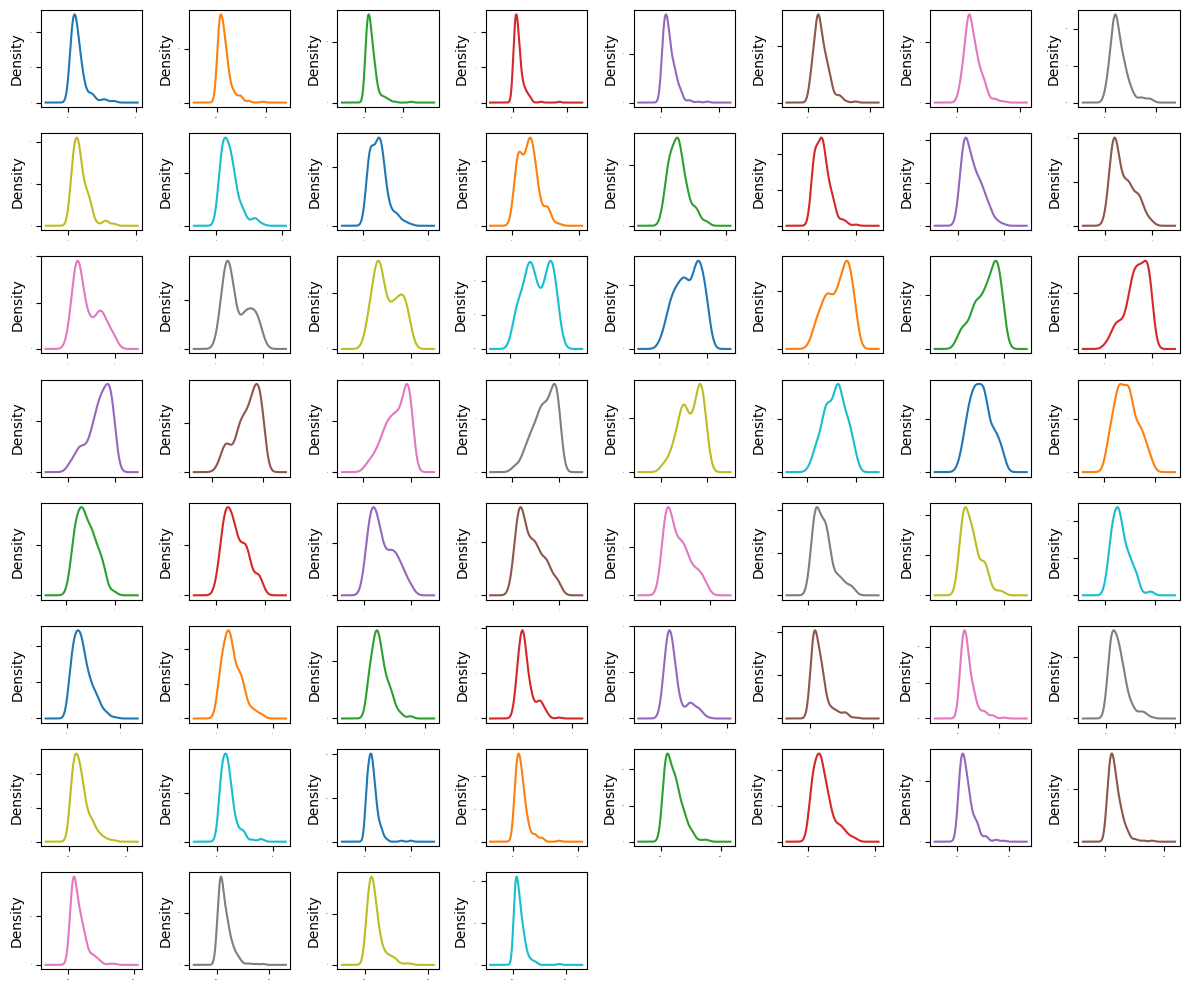

In [9]:
# density plot for each attribute
dataset.plot(
    kind="density",
    subplots=True,
    layout=(8, 8),
    figsize=(12, 10),
    sharex=False,
    legend=False,
    fontsize=1,
)
plt.tight_layout()
plt.show()

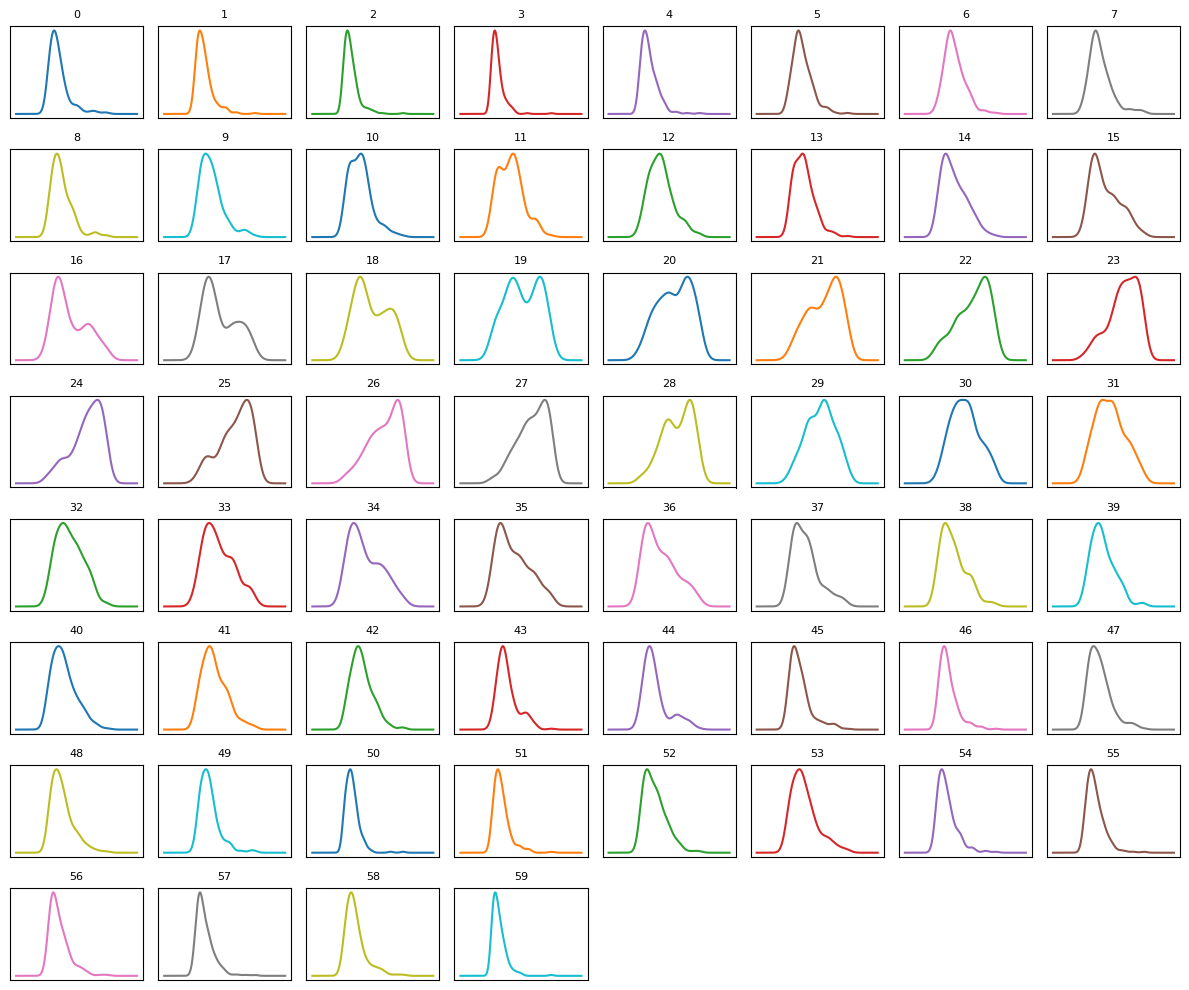

In [10]:
axes = dataset.plot(
    kind="density",
    subplots=True,
    layout=(8, 8),
    figsize=(12, 10),
    sharex=False,
    legend=False,
)

for i, ax in enumerate(axes.flatten()):
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    if i < len(dataset.columns):
        ax.set_title(str(i), fontsize=8)

plt.tight_layout()
plt.show()

### Multivariate Data Visualizations

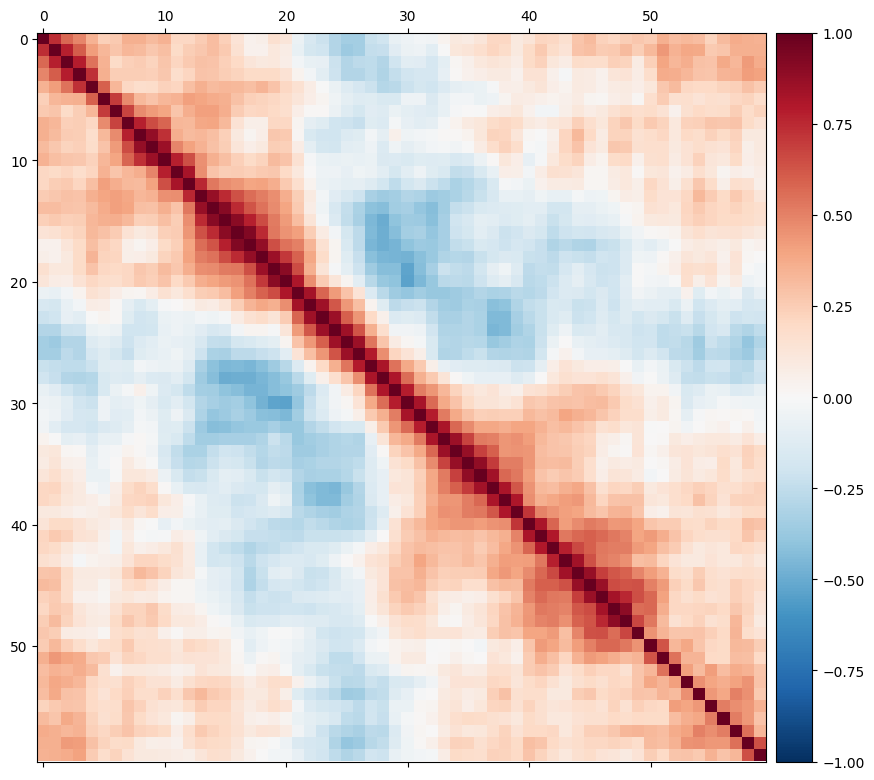

In [11]:
# correlation matrix
numeric_df = dataset.select_dtypes(include=[np.number])
corr = numeric_df.corr()

fig, ax = plt.subplots(figsize=(10, 10))

norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

cax = ax.matshow(corr, cmap="RdBu_r", norm=norm, interpolation="none")

divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)

fig.colorbar(cax, cax=cbar_ax)
plt.show()

### **Validation Dataset**

In [12]:
# Split-out validation dataset
array = dataset.values
X = array[:, 0:60].astype(float)
y = array[:, 60]
validation_size = 0.20
seed = 7
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=validation_size, random_state=seed
)

### **Evaluate Algorithms: Baseline**

In [13]:
# Test options and evaluation metrics
seed = 7
scoring = "accuracy"
num_folds = 10

In [14]:
# Spot-Check Algorithms
models = []
models.append(("LR", LogisticRegression(solver="lbfgs", max_iter=1000)))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
models.append(("SVM", SVC(gamma="auto")))

In [15]:
# Compare Algorithms
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

LR: 0.7717 (0.0910)
LDA: 0.7787 (0.0936)
KNN: 0.7588 (0.1064)
CART: 0.7048 (0.1215)
NB: 0.6827 (0.1360)
SVM: 0.5658 (0.1413)


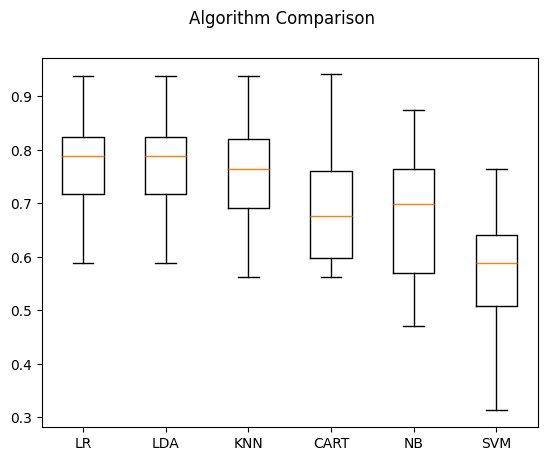

In [16]:
# Compare Algorithms Visually
fig = plt.figure()
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### **Evaluate Algorithms: Standardize Data**

In [17]:
# Standardize the dataset
pipelines = []
pipelines.append(
    (
        "ScaledLR",
        Pipeline(
            [
                ("Scaler", StandardScaler()),
                ("LR", LogisticRegression(solver="lbfgs", max_iter=1000)),
            ]
        ),
    )
)
pipelines.append(
    (
        "ScaledLDA",
        Pipeline([("Scaler", StandardScaler()), ("LDA", LinearDiscriminantAnalysis())]),
    )
)
pipelines.append(
    (
        "ScaledKNN",
        Pipeline([("Scaler", StandardScaler()), ("KNN", KNeighborsClassifier())]),
    )
)
pipelines.append(
    (
        "ScaledCART",
        Pipeline([("Scaler", StandardScaler()), ("CART", DecisionTreeClassifier())]),
    )
)
pipelines.append(
    ("ScaledNB", Pipeline([("Scaler", StandardScaler()), ("NB", GaussianNB())]))
)
pipelines.append(
    ("ScaledSVM", Pipeline([("Scaler", StandardScaler()), ("SVM", SVC(gamma="auto"))]))
)

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

ScaledLR: 0.7544 (0.0679)
ScaledLDA: 0.7787 (0.0936)
ScaledKNN: 0.8085 (0.1080)
ScaledCART: 0.7103 (0.0855)
ScaledNB: 0.6827 (0.1360)
ScaledSVM: 0.8261 (0.0818)


<hr style="height:4px; background-color:#ff0000; border:none;">

### **Visualising the two sets of results**

A minor sidetrack project of my own.

In [18]:
# Collect the results (means) for both runs


def cv_mean_scores(model_list, X, y, num_folds=10, seed=7, scoring="accuracy"):
    scores = {}
    for name, model in model_list:
        kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        scores[name] = cv_results.mean()
        print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")
    return scores


# Run both experiments
unscaled_means = cv_mean_scores(models, X_train, y_train, num_folds, seed, scoring)
scaled_means = cv_mean_scores(pipelines, X_train, y_train, num_folds, seed, scoring)

LR: 0.7717 (0.0910)
LDA: 0.7787 (0.0936)
KNN: 0.7588 (0.1064)
CART: 0.7397 (0.1175)
NB: 0.6827 (0.1360)
SVM: 0.5658 (0.1413)
ScaledLR: 0.7544 (0.0679)
ScaledLDA: 0.7787 (0.0936)
ScaledKNN: 0.8085 (0.1080)
ScaledCART: 0.7232 (0.0754)
ScaledNB: 0.6827 (0.1360)
ScaledSVM: 0.8261 (0.0818)


In [19]:
# Align names and build a table for plotting

base_names = list(unscaled_means.keys())

df_plot = pd.DataFrame(
    {
        "Algorithm": base_names,
        "Unscaled": [unscaled_means[name] for name in base_names],
        "Scaled": [scaled_means.get("Scaled" + name, np.nan) for name in base_names],
    }
)

print(df_plot)

  Algorithm  Unscaled    Scaled
0        LR  0.771691  0.754412
1       LDA  0.778676  0.778676
2       KNN  0.758824  0.808456
3      CART  0.739706  0.723162
4        NB  0.682721  0.682721
5       SVM  0.565809  0.826103


In [20]:
# Add improvement + sort
df_sorted = df_plot.copy()

# improvement due to scaling
df_sorted["Improvement"] = df_sorted["Scaled"] - df_sorted["Unscaled"]

# sort (largest improvement at top)
df_sorted = df_sorted.sort_values(by="Improvement", ascending=False).reset_index(
    drop=True
)
print(df_sorted)

  Algorithm  Unscaled    Scaled  Improvement
0       SVM  0.565809  0.826103     0.260294
1       KNN  0.758824  0.808456     0.049632
2        NB  0.682721  0.682721     0.000000
3       LDA  0.778676  0.778676     0.000000
4      CART  0.739706  0.723162    -0.016544
5        LR  0.771691  0.754412    -0.017279


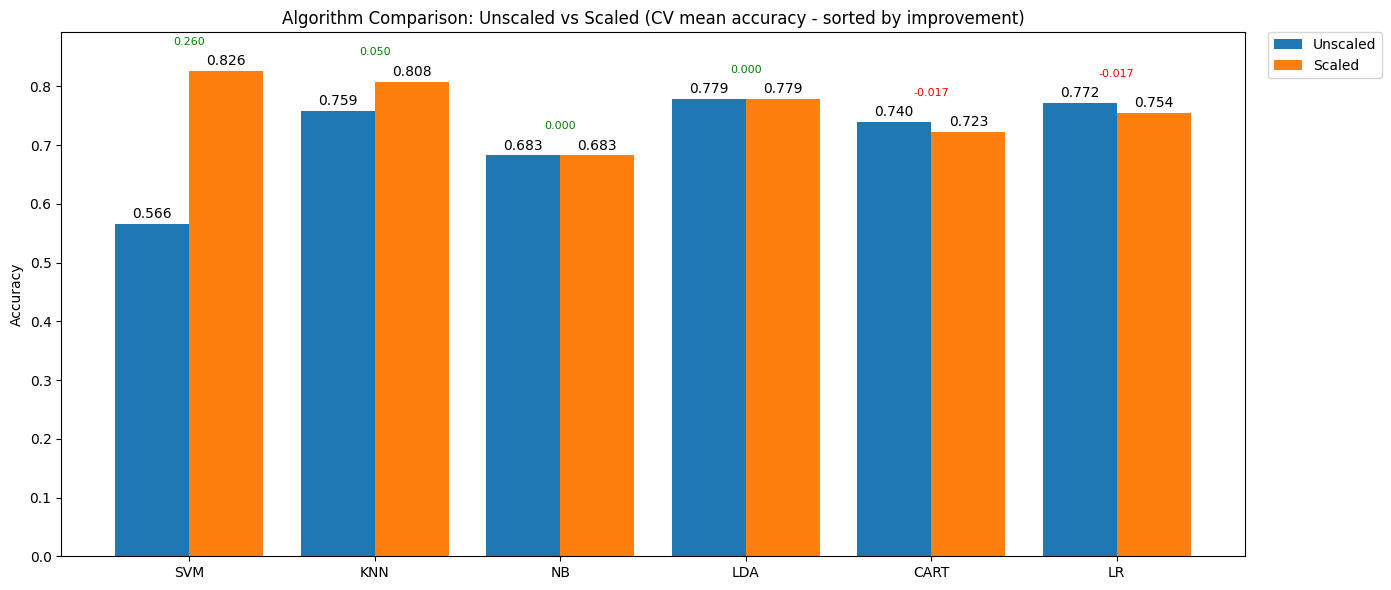

In [21]:
# Plot grouped bars (Unscaled vs Scaled)

x = np.arange(len(df_sorted["Algorithm"]))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(x - width / 2, df_sorted["Unscaled"], width, label="Unscaled")
ax.bar(x + width / 2, df_sorted["Scaled"], width, label="Scaled")

ax.set_xticks(x)
ax.set_xticklabels(df_sorted["Algorithm"])
ax.set_ylabel("Accuracy")
ax.set_title(
    "Algorithm Comparison: Unscaled vs Scaled (CV mean accuracy - sorted by improvement)"
)
ax.legend()

for bars in ax.containers:
    ax.bar_label(bars, fmt="%.3f", padding=2)

ax.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
)

fig.set_size_inches(14, 6)

# y_padding = 0.05 * (df_sorted[["Unscaled", "Scaled"]].values.max())
tops = df_sorted[["Unscaled", "Scaled"]].values.max(axis=1)
y_padding = 0.05 * tops.max()

# for i, imp in enumerate(df_sorted["Improvement"]):
#     ax.text(
#         i,
#         max(df_sorted["Unscaled"][i], df_sorted["Scaled"][i]) + 0.005,
#         f"+{imp:.3f}",
#         ha="center",
#         va="bottom",
#         fontsize=8,
#         color="green" if imp >= 0 else "red",
#     )

for i, row in df_sorted.iterrows():
    top_of_bars = max(row["Unscaled"], row["Scaled"])
    ax.text(
        i,
        top_of_bars + y_padding,
        f"{row['Improvement']:.3f}",
        ha="center",
        va="bottom",
        fontsize=8,
        color="green" if row["Improvement"] >= 0 else "red",
        clip_on=False,
    )

# expand y-limits to make room for labels
y_max = tops.max() + (y_padding * 1.6)
ax.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

That worked ok.

<hr style="height:4px; background-color:#ff0000; border:none;">

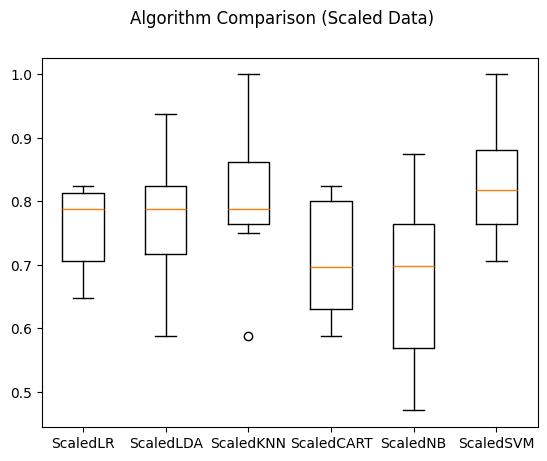

In [22]:
# Compare Algorithms with boxplots
fig = plt.figure()
fig.suptitle("Algorithm Comparison (Scaled Data)")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### **Algorithm Tuning**

### Tuning KNN

The default number of neighbors is 7. Try all odd values of *k* from 1 to 21. Each *k* value is evaluated using 10-fold cross-validation on the training standardized dataset.

In [23]:
# Tune scaled KNN
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print(f"Best: {grid_result.best_score_:.4f} using {grid_result.best_params_}")
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.4f} ({stdev:.4f}) with: {param}")

Best: 0.8360 using {'n_neighbors': 1}
0.8360 (0.0795) with: {'n_neighbors': 1}
0.8136 (0.0880) with: {'n_neighbors': 3}
0.8143 (0.0969) with: {'n_neighbors': 5}
0.7776 (0.1204) with: {'n_neighbors': 7}
0.7301 (0.0994) with: {'n_neighbors': 9}
0.7415 (0.0740) with: {'n_neighbors': 11}
0.7107 (0.1058) with: {'n_neighbors': 13}
0.7232 (0.0810) with: {'n_neighbors': 15}
0.6989 (0.0727) with: {'n_neighbors': 17}
0.7107 (0.0913) with: {'n_neighbors': 19}
0.6989 (0.0912) with: {'n_neighbors': 21}


### Tuning SVM

SVM algorithm has two key parameters to tune: the value of *C* (how much to relax the margin) and the type of `kernel`. The default for SVM is to use the Radial Base Function (RBF) kernel with a *C* value set to 1.0. Perform a grid search using 10-fold cross-validation with a standardized copy of the training dataset.

In [24]:
# Tune scaled SVM model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0, 2.5, 3.0]
kernel_values = ["linear", "poly", "rbf", "sigmoid"]
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC(gamma="auto")
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print(f"Best: {grid_result.best_score_:.4f} using {grid_result.best_params_}")
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.4f} ({stdev:.4f}) with: {param}")

Best: 0.8559 using {'C': 3.0, 'kernel': 'poly'}
0.7485 (0.0700) with: {'C': 0.1, 'kernel': 'linear'}
0.5710 (0.1314) with: {'C': 0.1, 'kernel': 'poly'}
0.6011 (0.1844) with: {'C': 0.1, 'kernel': 'rbf'}
0.7129 (0.1166) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.7544 (0.0823) with: {'C': 0.3, 'kernel': 'linear'}
0.6566 (0.1044) with: {'C': 0.3, 'kernel': 'poly'}
0.7482 (0.0853) with: {'C': 0.3, 'kernel': 'rbf'}
0.7489 (0.0784) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.7658 (0.0703) with: {'C': 0.5, 'kernel': 'linear'}
0.7044 (0.1103) with: {'C': 0.5, 'kernel': 'poly'}
0.7724 (0.0818) with: {'C': 0.5, 'kernel': 'rbf'}
0.7607 (0.0656) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.7599 (0.0832) with: {'C': 0.7, 'kernel': 'linear'}
0.7537 (0.0951) with: {'C': 0.7, 'kernel': 'poly'}
0.8143 (0.0598) with: {'C': 0.7, 'kernel': 'rbf'}
0.7669 (0.0728) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.7654 (0.0670) with: {'C': 0.9, 'kernel': 'linear'}
0.7838 (0.0937) with: {'C': 0.9, 'kernel': 'poly'}
0.8140 (0.0667) 

### **Ensemble Methods**

- **Boosting Methods**: AdaBoost (AB) and Gradient Boosting (GBM)
- **Bagging Methods**: Random Forests (RF) and Extra Trees (ET)

No data standardization is used because all four ensemble algorithms are based on decision trees that are less sensitive to data distributions.

In [25]:
# Ensemble Methods
ensembles = []
ensembles.append(("AB", AdaBoostClassifier()))
ensembles.append(("GBM", GradientBoostingClassifier()))
ensembles.append(("RF", RandomForestClassifier(n_estimators=10)))
ensembles.append(("ET", ExtraTreesClassifier(n_estimators=10)))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

AB: 0.8018 (0.0873)
GBM: 0.8018 (0.1348)
RF: 0.7893 (0.0923)
ET: 0.8011 (0.1166)


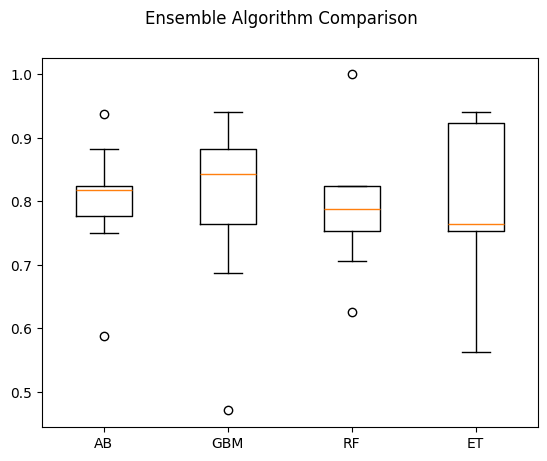

In [26]:
# Compare Ensemble Algorithms Visually
fig = plt.figure()
fig.suptitle("Ensemble Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### **Finalize Model (SVM)**

In [27]:
# prepare the final model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = SVC(C=3.0, kernel="poly", gamma="auto")
model.fit(rescaledX, y_train)

# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.8333333333333334
[[23  4]
 [ 3 12]]
              precision    recall  f1-score   support

           M       0.88      0.85      0.87        27
           R       0.75      0.80      0.77        15

    accuracy                           0.83        42
   macro avg       0.82      0.83      0.82        42
weighted avg       0.84      0.83      0.83        42

